# Transformer

In de code in deze notebook gaan we een transformer opstellen voor een vertaling uit te voeren.
De tutorial waar deze code is op gebaseerd vind je [hier](https://www.tensorflow.org/text/tutorials/transformer).
In deze tutorial staat de nodige code om een vertaler te maken van portugees naar engels.

In [ ]:
!pip install tensorflow_text --user

In [1]:
#imports
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [2]:
#download dataset
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [3]:
# example of data
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('> Examples in Portuguese:')
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))
        print()

    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .

mas e se estes fatores fossem ativos ?

mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [4]:
# setup tokenizer
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(model_name)

In [5]:
# originele input (decode is gewoon om speciale karakters correct uit te lezen)
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

# zet elke string om naar tokens
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

# zet de lijst met tokens terug om naar een string
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

# lookup kan gebruikt worden om de lijst met tokens van een sequentie te bekomen
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .
> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

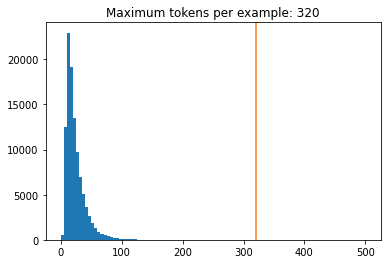

In [6]:
# histogram of number of tokens
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

## Setting up data pipeline

We gaan hier op een lichtjes andere manier werken dan we tot nu gedaan hebben.
We gaan hier een functie opstellen die elke zin gaat omzetten naar de nodige inputs en outputs.
Hierbij gaan we de volgende stappen uitvoeren:
* Tokenize zinnen
* Trim zinnen naar een maximum aantal tokens
* Splits de engels data in inputs en labels (dit is hetzelfde maar 1 tijdsstap verschoven)
* Hierboven zie je dat je na de tokenize een RaggedTensor bekomt. Zet deze om naar een DenseTensor
* Return de data als (inputs, outputs)

In [7]:
# preprocessing steps

MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)        # deze kan je in de fit gebruiken
val_batches = make_batches(val_examples)

In [9]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

print(en[0][:10])
print(en_labels[0][:10])

(64, 96)
(64, 84)
(64, 84)
tf.Tensor([  2  87  45 149  50   9  56 132 119  15], shape=(10,), dtype=int64)
tf.Tensor([ 87  45 149  50   9  56 132 119  15   3], shape=(10,), dtype=int64)


## Opstellen model

Het transformer model dat we gaan opstellen is een 4-layer transformer.
De structuur van het model dat we gaan opstellen ziet er uit als volgt

<img src="architecture.png" alt="transformer" width="200"/>

Zoals we daarnet gezien hebben bestaat dit uit een aantal componenten, namelijk:
* Embedding/Positional encoding layer
* Add and normalize stappen
* Base Attention layer
* Cross Attention layer
* Global self Attention layer
* Causal self Attention layer
* Feed forward network
* Encoder 
* Decoder

Elk van deze componenten worden nu 1 voor 1 uitgewerkt.

### Embedding/Positional encoding layer

Een transformer gebruikt geen recurrentie om de volgorde van de woorden bij te houden (om parallellisatie mogelijk te maken).
Deze volgorde is echter heel belangrijk om de correcte betekenis van een zin te bepalen.
Hierdoor is het belangrijk om deze informatie aan de inputs toe te voegen.
Dit is wat er gebeurd in dit deel van de transformer.

<img src="emb_pos_encoding_layer.png" alt="encoding_layer" width="400"/>

In [10]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

De wiskunde van bovenstaande functie moet je niet kennen. Deze is gekopieerd uit de tutorial maar kan je online vinden.
Het is wel interessant om te weten dat we net zoals in signaalverwerken elke willekeurige functie kunnen samenstellen door sinus-functies te combineren.
Een gelijkaardig effect gebeurd er hier.
Dit kan je zien aan de hand van onderstaande code.

(2048, 512)


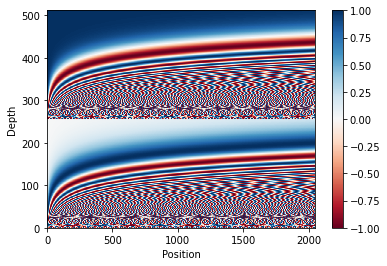

In [11]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Van bovenstaande functie kunnen we dan een custom laag maken als volgt.

In [12]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model    # scaling factor voor grootte van embedding en positional encoding waarden
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)     # int tokens to an embedding (resolution reduction)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    
    x = x + self.pos_encoding[tf.newaxis, :length, :] # positional encoding
    return x

embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
en_emb._keras_mask  # dit is een mask om ervoor te zorgen dat er geen woorden uit de toekomst gebruikt kunnen worden om engelse tekst te genereren

<tf.Tensor: shape=(64, 84), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add en normalization blokken.

Deze stukjes zijn verspreid over het hele netwerk.
Om deze te implementeren kunnen eenvoudigweg de Add en LayerNormalization lagen gebruikt worden.
Het is belangrijk in deze context om de Add layer te gebruiken en niet de standaard + functie omdat de Add layer de masks behoudt wat niet het geval is bij de + operatie.
Het nut van deze functies is om het trainen efficienter te maken door de Gradient eenvoudiger door te geven en de schaal van de parameters redelijk te houden.
Omdat deze blokken in de verschillende delen voorkomen gaan we de blokken toevoegen aan de verschillende stukken en niet apart een layer voor maken.

<img src="add_norm.png" alt="adding en normalization" width="400"/>

### Base attention layer

Doorheen het model worden er verscheidene attention layers gebruikt die steeds heel sterk op elkaar lijken (zie onderstaande figuur).
Deze drie delen bestaan steeds uit een opeenvolging van een multihead-attention layer, layernormalization en add layer.
Deze drie lagen kunnen apart toegevoegd worden aan het model door middel van de functional API maar het kan handig zijn om ze te groeperen in een custom layer.
Dit om ervoor te zorgen dat er geen laag vergeten kan worden.

<img src="base_attention.png" alt="base attention" width="400"/>

In [13]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### Cross attention layer

Het centrale deel van de transformer is de cross attention layer.
Deze maakt namelijk een combinatie van de encoder en decoder.
Deze layer is op zich een kleine aanpassing van de Base Attention layer hierboven beschreven.

<img src="cross_attention.png" alt="cross attention" width="400"/>

In [14]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # x is de engelse tekst, context de info uit de encoder/portugese tekst
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    # add normalization blok
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [7]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

# test voor de dimensies -> merk op dat de shape hetzelfde is als de engelse embedding
print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

NameError: name 'CrossAttention' is not defined

### Global self attention layer

Deze attention layer is belangrijk om ervoor te zorgen dat de input tekst geanalyseerd wordt.
Dit geeft de context die gebruikt wordt om de vertaalde engelse zin op te stellen.
Bij de oudere RNN netwerken werden hiervoor Bidirectional RNN lagen gebruikt.
Dit had echter een aantal problemen door de beperkte mogelijkheden voor parallellisatie en het vanishing gradient problem.

De global self attention layer vermijdt deze problemen door de hele sequentie in parallel te bekijken.
Dit is ook een aanpassingen op de base attention layer en kan uitgevoerd worden als volgt:

<img src="global_self_attention.png" alt="global self attention" width="400"/>

In [16]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 96, 512)
(64, 96, 512)


Deze laag wordt self attention genoemd omdat de uuery en de key-values uit dezelfde input komt (zie onderstaande figuur)

<img src="self_attention.png" alt="self attention" width="400"/>

### Causal self attention layer

De laatste attention layer is de causal self attention layer.
Dit is analoog aan de global self attention layer maar voor de engelse tekst.
Hier is de mask een belangrijk onderdeel van om ervoor te zorgen dat een woord enkel bepaald kan worden door woorden die in het verleden reeds berekend zijn (causal).

Een causal model is efficient door de volgende twee redenen:
* De hele output sequentie kan in 1 keer berekend worden (in parallel)
* Voor elk nieuw token dat berekend moet worden kan je reeds berekende outputs hergebruiken.

<img src="causal_self_attention.png" alt="causal self attention" width="400"/>

Door de mask ziet deze laag er als volgt uit:

<img src="causal_attention.png" alt="causal attention" width="400"/>

In [17]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

(64, 84, 512)
(64, 84, 512)


0.00011241436

### Feedforward 

Het laatste grote deel van de transformers zijn de feedforward blokken.
Ook deze kunnen eenvoudig samengesteld worden door de functional api te gebruiken maar naar analogie met de vorige stappen maken we ook hiervoor een aparte laag.
Deze feedforward blokken bestaan uit de volgende stappen

<img src="feedforward.png" alt="causal attention" width="400"/>

In [18]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 84, 512)
(64, 84, 512)


### Encoder

De encoder bestaat uit N keer een encoder layer.
Deze layer bestaat uit de volgende stappen:
* Global self attention
* Feedforward layer

<img src="encoder_layer.png" alt="causal attention" width="400"/>

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 96, 512)
(64, 96, 512)


De encoder is dan een samenstelling van N keer bovenstaande laag.
Deze custom laag kan samengesteld worden als volgt:

In [20]:
# de encoder bestaat uit
# de embedding laag
# N keer de encoding layer (global self + feed forward)

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 96)
(64, 96, 512)


### Decoder layer

Naast het encoder gedeelte bestaat uit een transformer ook uit een decoder gedeelte.
Deze decoder bestaat net als de encoder uit een aantal decoding lagen.
De decoding laag bestaat uit de volgende drie lagen:
* Causal self attention layer
* Cross attention layer
* Feed forward network

<img src="decoder_layer.png" alt="decoder layer" width="400"/>

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 84, 512)
(64, 96, 512)
(64, 84, 512)


De decoder bestaat dan uit de positional en embedding encoder en dan een opeenvolging van decoder layers.
Dit ziet er uit als volgt:

In [22]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

(64, 84)
(64, 96, 512)
(64, 84, 512)


TensorShape([64, 8, 84, 96])

## Samenstellen van de transformer

Nu de code van de verschillende onderdelen is opgesteld kan de gehele transformer samengesteld en getrained worden.
Dit model ziet er uit als volgt:

In [23]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

Zoals je in de code hierboven kan zien, zijn er een aantal hyperparameters die nog gekozen kunnen worden:
* num_layers: aantal encoding/decoding layers
* d_model: dimensionality van de embeddings 
* num_heads: number of attention vectors per woord
* dff: aantal neurons in de feed forward blokken
* dropout_rate

Hieronder staat de keuzes uit de tutorial. Deze zijn iets lager dan de originele versies uit de paper om performantieredenen.

In [24]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [25]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

transformer.summary()

(64, 84)
(64, 96)
(64, 84, 7010)
(64, 8, 84, 96)
Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


Dit model kan getrained worden als volgt:

In [57]:
# loss function rekening houdend met het mask (niet kijken naar de toekomst)
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# accuracy bereken, rekening houdend met het mask
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

transformer.compile(
    loss=masked_loss,
    optimizer="adam",
    metrics=[masked_accuracy])

In [58]:
with tf.device("CPU:0"):
    transformer.fit(train_batches,
                epochs=5,
                validation_data=val_batches)        # te groot voor mijn GPU -> op mijn CPU duurt dit 1 uur per epoch

Epoch 1/5


het getrainde model kan nu gebruikt worden om portugees te vertalen naar engels.
Hiervoor moeten de volgende stappen uitgevoerd worden:
* Encode inputs met de Portugeze tokenizer (encoder input)
* Initialiseer de decoder input met het **Start** token
* Bereken de padding masks en look ahead masks
* De decoder berekend dan voorspellingen door te kijken naar de encoder output en zijn eigen output
* Concateneer het voorspelde token met de input van de decoder
* Maak een nieuwe voorspelling voor het volgende woord

Deze stappen gebeuren in de volgende code

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
# example 1
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

TypeError: Cannot iterate over a scalar tensor.

In [ ]:
#example 2
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
# example 3
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Een andere manier om de interne werking van het model te bestuderen is door te kijken naar de gewichten waarop gelet worden in de attention layers

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)


def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Het model kan ook vrij goed omgaan met woorden die nog nooit gezien zijn.
Bijvoorbeelde de woorden triceratops en encyclopedia zijn niet aanwezig in de dataset en dan wordt de volgende zin vertaald als:

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

Hieronder staat nog de benodigde code om de translate te bewaren en opnieuw in te laden

In [ ]:
# saving the translator
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

translator = ExportTranslator(translator)

sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."
print(translator(sentence).numpy())

tf.saved_model.save(translator, export_dir='translator')

In [ ]:
translator = tf.saved_model.load('translator')

sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."
print(translator(sentence).numpy())

b'thank you .'
